In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import seaborn as sns
import cmcrameri.cm as cmc

import astropy.constants as const

from eggman.grid import calculate_eep

In [2]:
filename = "/mnt/data-storage/yaguangli2023/stellar-models/grid_models_surface_effect_uncorrected/grid.h5"
tracks = pd.read_hdf(filename, "tracks")
tracks.head()

,star_mass,Yinit,Zinit,amlt,fov_core,fov_shell
track,,,,,,
7000,0.92329,0.279311,0.001829,1.608258,0.000000,0.006041
7001,1.72329,0.229311,0.010871,2.308258,0.012396,0.006041
7002,2.12329,0.304311,0.004172,2.658258,0.015861,0.006041
7003,1.32329,0.254311,0.024469,1.958258,0.002481,0.006041
7004,1.12329,0.291811,0.006519,2.133258,0.000000,0.006041


In [3]:
stars = pd.read_hdf(filename, "stars")
stars.head()

star_age    radius         Teff  center_h1    log_LHe  \
track star                                                              
7000  1     2.220454e+07  0.893151  6382.509287   0.718192 -45.291905   
      2     2.300916e+07  0.891027  6377.312552   0.718122 -45.308912   
      3     2.397470e+07  0.890320  6373.785487   0.718037 -45.328570   
      4     3.019433e+07  0.893682  6371.412400   0.717474 -45.392646   
      5     3.259691e+07  0.894573  6371.453759   0.717253 -45.402736   

            log_Lnuc  Dnu_freq_o     eps_o  delta_Pg  
track star                                            
7000  1     0.078416  148.565794  1.129515       0.0  
      2     0.077135  149.148739  1.131800       0.0  
      3     0.075916  149.362908  1.132830       0.0  
      4     0.075178  148.552167  1.130613       0.0  
      5     0.075810  148.331713  1.129892       0.0

In [4]:
grid = tracks.join(stars).reset_index()
grid.head()

,track,star,star_mass,Yinit,Zinit,amlt,fov_core,fov_shell,star_age,radius,Teff,center_h1,log_LHe,log_Lnuc,Dnu_freq_o,eps_o,delta_Pg
0,7000,1,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,2.220454e+07,0.893151,6382.509287,0.718192,-45.291905,0.078416,148.565794,1.129515,0.0
1,7000,2,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,2.300916e+07,0.891027,6377.312552,0.718122,-45.308912,0.077135,149.148739,1.131800,0.0
2,7000,3,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,2.397470e+07,0.890320,6373.785487,0.718037,-45.328570,0.075916,149.362908,1.132830,0.0
3,7000,4,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,3.019433e+07,0.893682,6371.412400,0.717474,-45.392646,0.075178,148.552167,1.130613,0.0
4,7000,5,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,3.259691e+07,0.894573,6371.453759,0.717253,-45.402736,0.075810,148.331713,1.129892,0.0


In [5]:
constants = pd.read_hdf(filename, "constants")
constants

msun    1.988410e+33
rsun    6.957000e+10
lsun    3.828000e+33
Tsun    5.772003e+03
dtype: float64

In [6]:
grid["luminosity"] = grid.radius**2 * (grid.Teff/constants.Tsun)**4
grid["log_L"] = np.log10(grid.luminosity)
grid["log_Zinit"] = np.log10(grid.Zinit)
grid["log_age"] = np.log10(grid.star_age)
grid["log_g"] = np.log10(
    const.G.cgs * constants.msun * grid.star_mass / constants.rsun**2 / grid.radius**2
)
grid["log_R"] = np.log10(grid.radius)
grid["log_Teff"] = np.log10(grid.Teff)
grid["log_Dnu"] = np.log10(grid.Dnu_freq_o)

In [7]:
grid["f_nuc"] = 10**(grid.log_Lnuc - grid.log_L)
grid["log_f_He"] = (grid.log_LHe - grid.log_L)

In [8]:
grid["Xinit"] = 1 - grid.Yinit - grid.Zinit
grid["delta_X"] = grid.Xinit - grid.center_h1

In [9]:
solar_g = const.G.cgs.value * constants.msun / constants.rsun**2

In [10]:
solar_numax = 3100.
grid["log_numax"] = grid.log_g - np.log10(solar_g) \
    - 0.5 * (grid.log_Teff - np.log10(constants.Tsun)) \
    + np.log10(solar_numax)
grid["numax"] = 10**grid.log_numax

In [11]:
grid["density"] = grid.star_mass / grid.radius**3

In [12]:
grid = grid.dropna()
grid.head()

,track,star,star_mass,Yinit,Zinit,amlt,fov_core,fov_shell,star_age,radius,...,log_R,log_Teff,log_Dnu,f_nuc,log_f_He,Xinit,delta_X,log_numax,numax,density
0,7000,1,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,2.220454e+07,0.893151,...,-0.049075,3.804991,2.171919,1.004400,-45.368414,0.71886,0.000668,3.533018,3412.068710,1.295877
1,7000,2,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,2.300916e+07,0.891027,...,-0.050109,3.804638,2.173620,1.009506,-45.381938,0.71886,0.000738,3.535262,3429.746944,1.305163
2,7000,3,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,2.397470e+07,0.890320,...,-0.050454,3.804397,2.174243,1.010508,-45.399945,0.71886,0.000823,3.536072,3436.149888,1.308277
3,7000,4,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,3.019433e+07,0.893682,...,-0.048817,3.804236,2.171879,1.002710,-45.466649,0.71886,0.001386,3.532879,3410.979677,1.293567
4,7000,5,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,3.259691e+07,0.894573,...,-0.048384,3.804239,2.171234,1.002145,-45.477616,0.71886,0.001608,3.532013,3404.180139,1.289707


In [13]:
with open("central_hydrogen_problem_tracks.txt") as file:
    bad = list(map(int, file.read().split(",")))

In [14]:
grid = grid.drop(index=grid[grid.track.isin(bad)].index).reset_index()
grid.head()

,index,track,star,star_mass,Yinit,Zinit,amlt,fov_core,fov_shell,star_age,...,log_R,log_Teff,log_Dnu,f_nuc,log_f_He,Xinit,delta_X,log_numax,numax,density
0,0,7000,1,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,2.220454e+07,...,-0.049075,3.804991,2.171919,1.004400,-45.368414,0.71886,0.000668,3.533018,3412.068710,1.295877
1,1,7000,2,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,2.300916e+07,...,-0.050109,3.804638,2.173620,1.009506,-45.381938,0.71886,0.000738,3.535262,3429.746944,1.305163
2,2,7000,3,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,2.397470e+07,...,-0.050454,3.804397,2.174243,1.010508,-45.399945,0.71886,0.000823,3.536072,3436.149888,1.308277
3,3,7000,4,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,3.019433e+07,...,-0.048817,3.804236,2.171879,1.002710,-45.466649,0.71886,0.001386,3.532879,3410.979677,1.293567
4,4,7000,5,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,3.259691e+07,...,-0.048384,3.804239,2.171234,1.002145,-45.477616,0.71886,0.001608,3.532013,3404.180139,1.289707


In [15]:
zx_sun = 0.0181
grid["M_H"] = np.log10(grid["Zinit"]/grid["Xinit"]) - np.log10(zx_sun)

In [16]:
grid["log_mass"] = np.log10(grid.star_mass)

In [17]:
grid["log_kron"] = grid["log_age"] + 3.2 * grid["log_mass"]
grid["kron"] = 10**grid["log_kron"]

Let's assume we observe a star with T_eff and log(g). Draw a 3-sigma box and choose points in that box.

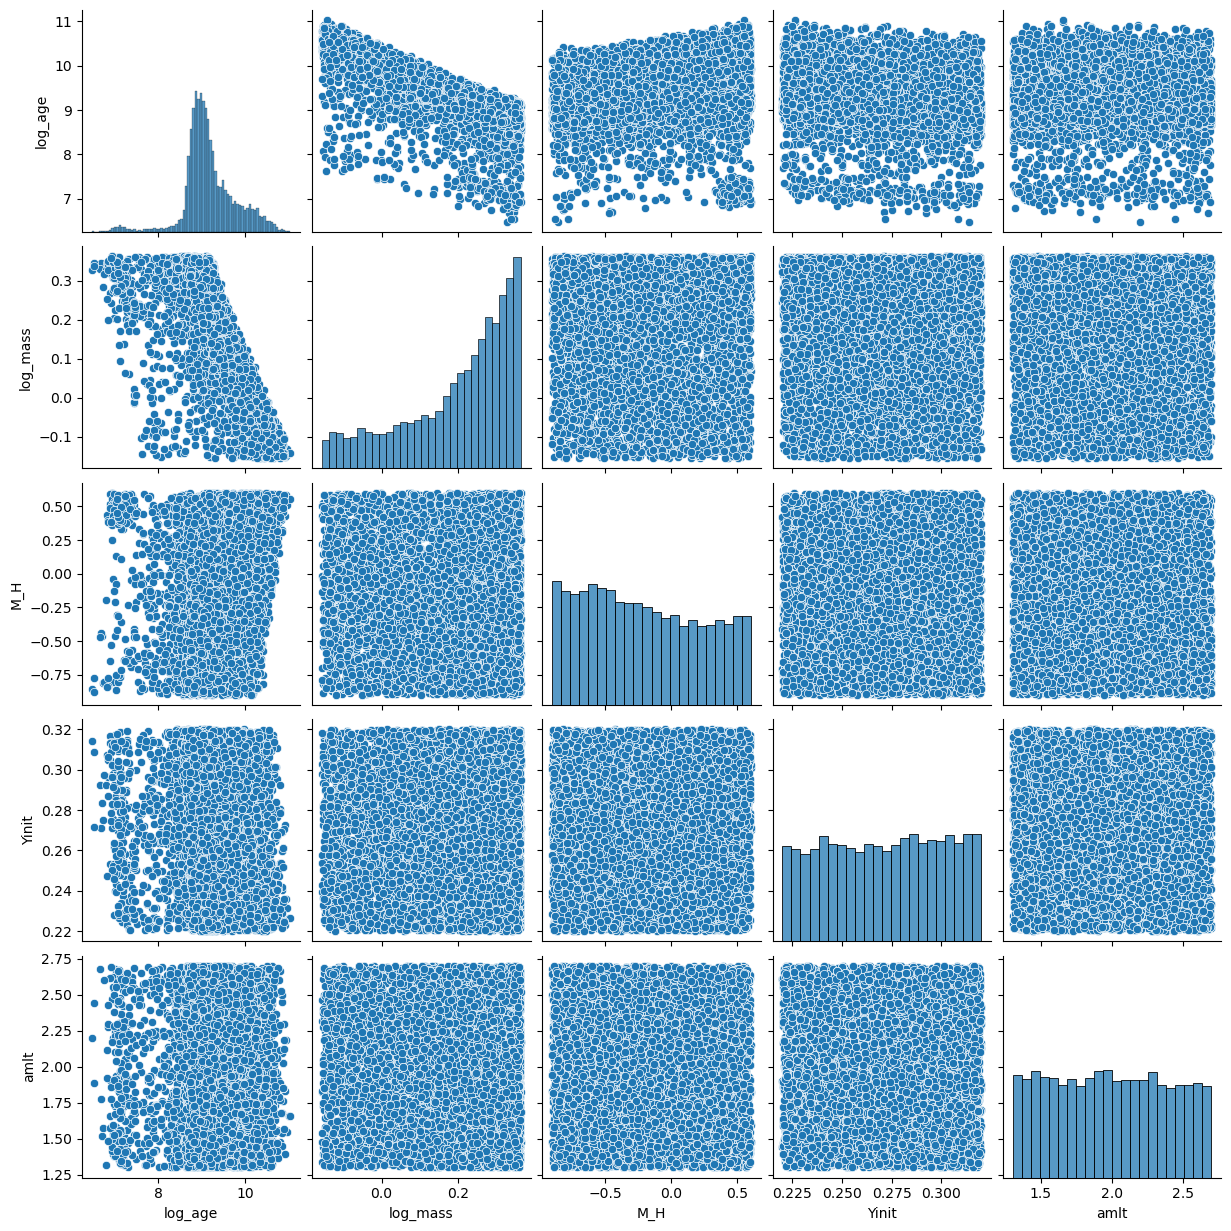

In [19]:
input_cols = ["log_age", "log_mass", "M_H", "Yinit", "amlt"]
# mask = grid.star_age < 14e9
sns.pairplot(grid.sample(10000), vars=input_cols)

In [20]:
corr = np.corrcoef(grid[input_cols].to_numpy().T)
corr

array([[ 1.00000000e+00, -7.60510231e-01,  1.73072469e-01,
        -1.44197878e-01,  2.85748447e-03],
       [-7.60510231e-01,  1.00000000e+00, -3.74814150e-02,
         2.18656548e-02, -1.14934482e-02],
       [ 1.73072469e-01, -3.74814150e-02,  1.00000000e+00,
        -4.85320759e-04, -7.06821567e-03],
       [-1.44197878e-01,  2.18656548e-02, -4.85320759e-04,
         1.00000000e+00,  8.79492164e-04],
       [ 2.85748447e-03, -1.14934482e-02, -7.06821567e-03,
         8.79492164e-04,  1.00000000e+00]])

In [21]:
import numpyro
import numpyro.distributions as dist
import jax
import jax.numpy as jnp
from jax import random, vmap
from corner import corner

rng = random.PRNGKey(0)

I0000 00:00:1700564543.037135  189282 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [22]:
from numpyro.distributions.util import clamp_probs

class TwoSidedTruncatedDistribution(dist.TwoSidedTruncatedDistribution):
    def icdf(self, u):
        loc = self.base_dist.loc
        sign = jnp.where(loc >= self.low, 1.0, -1.0)
        return (1 - sign) * loc + sign * self.base_dist.icdf(
            clamp_probs((1 - u) * self._tail_prob_at_low + u * self._tail_prob_at_high)
        )

def TruncatedNormal(loc=0.0, scale=1.0, *, low=None, high=None, validate_args=None):
    return TwoSidedTruncatedDistribution(
        dist.Normal(loc, scale), low=low, high=high, validate_args=validate_args
    )

In [23]:
from eggman.infer.models import lognorm_from_norm

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


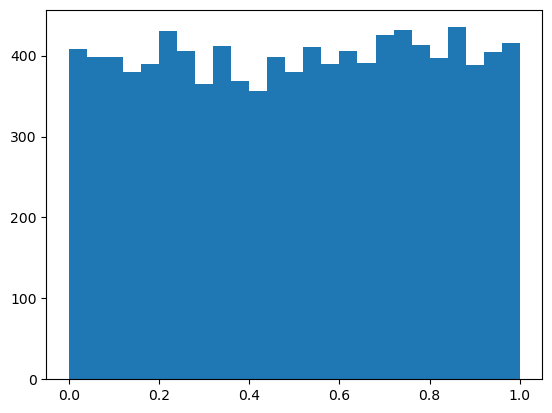

In [122]:
# x = dist.Beta(2, 1).sample(rng, sample_shape=(5000,))
x = dist.Gamma(1., np.log(10)).sample(rng, sample_shape=(10000,))
plt.hist(10**(-x), bins=25);
# plt.hist(x, bins=25);

The idea here is you start with a multivariate normal distribution and a correlation matrix. Then, you use the cdf to get uniform samples. Then you use the ppf to get new marginals

In [141]:
rng, key = random.split(rng)
normal = dist.MultivariateNormal(jnp.zeros(5), corr)
samples = normal.sample(key, sample_shape=(10000,))
uniform_samples = vmap(dist.Normal().cdf)(samples)

log_mass = TruncatedNormal(0.05, 0.15, low=jnp.log10(0.7), high=jnp.log10(2.3)).icdf(uniform_samples[:, 1])

log_kron_max = grid.log_kron.quantile(.99)
log_age_max = log_kron_max - 3.2 * log_mass
log_age_universe = 10 + np.log10(1.4)
log_age_high = np.minimum(log_age_max, log_age_universe)

log_age = TruncatedNormal(log_age_max+0.1, 0.4, low=7.0, high=log_age_high).icdf(uniform_samples[:, 0])
# log_age = TruncatedNormal(max_kron, 0.4, low=7.0, high=max_age).icdf(uniform_samples[:, 0])

# Gaussian copula of truncated normal distributions
xs = {
    "log_age_scaled": - dist.Gamma(1.0, jnp.log(10.0)).icdf(1.0 - uniform_samples[:, 0]),
    "log_mass": log_mass,
    "M_H": TruncatedNormal(0.0, 0.1, low=-0.9, high=0.5).icdf(uniform_samples[:, 2]),
    "Yinit": dist.Uniform(low=0.22, high=0.32).icdf(uniform_samples[:, 3]),
    "a_MLT": dist.Uniform(low=1.3, high=2.3).icdf(uniform_samples[:, 4])
}

In [153]:
# xs["log_age"] = xs["log_kron"] - 3.2 * xs["log_mass"]
# xs["age"] = 10**(xs["log_age"]-9)
xs["log_age"] = log_age_universe + xs["log_age_scaled"]
# xs["log_age"] = log_age_high + xs["log_age_scaled"]
xs["age"] = 10**xs["log_age"]
xs["mass"] = 10**xs["log_mass"]
# xs["age"] = xs["kron"] * xs["mass"]**(-3.2)

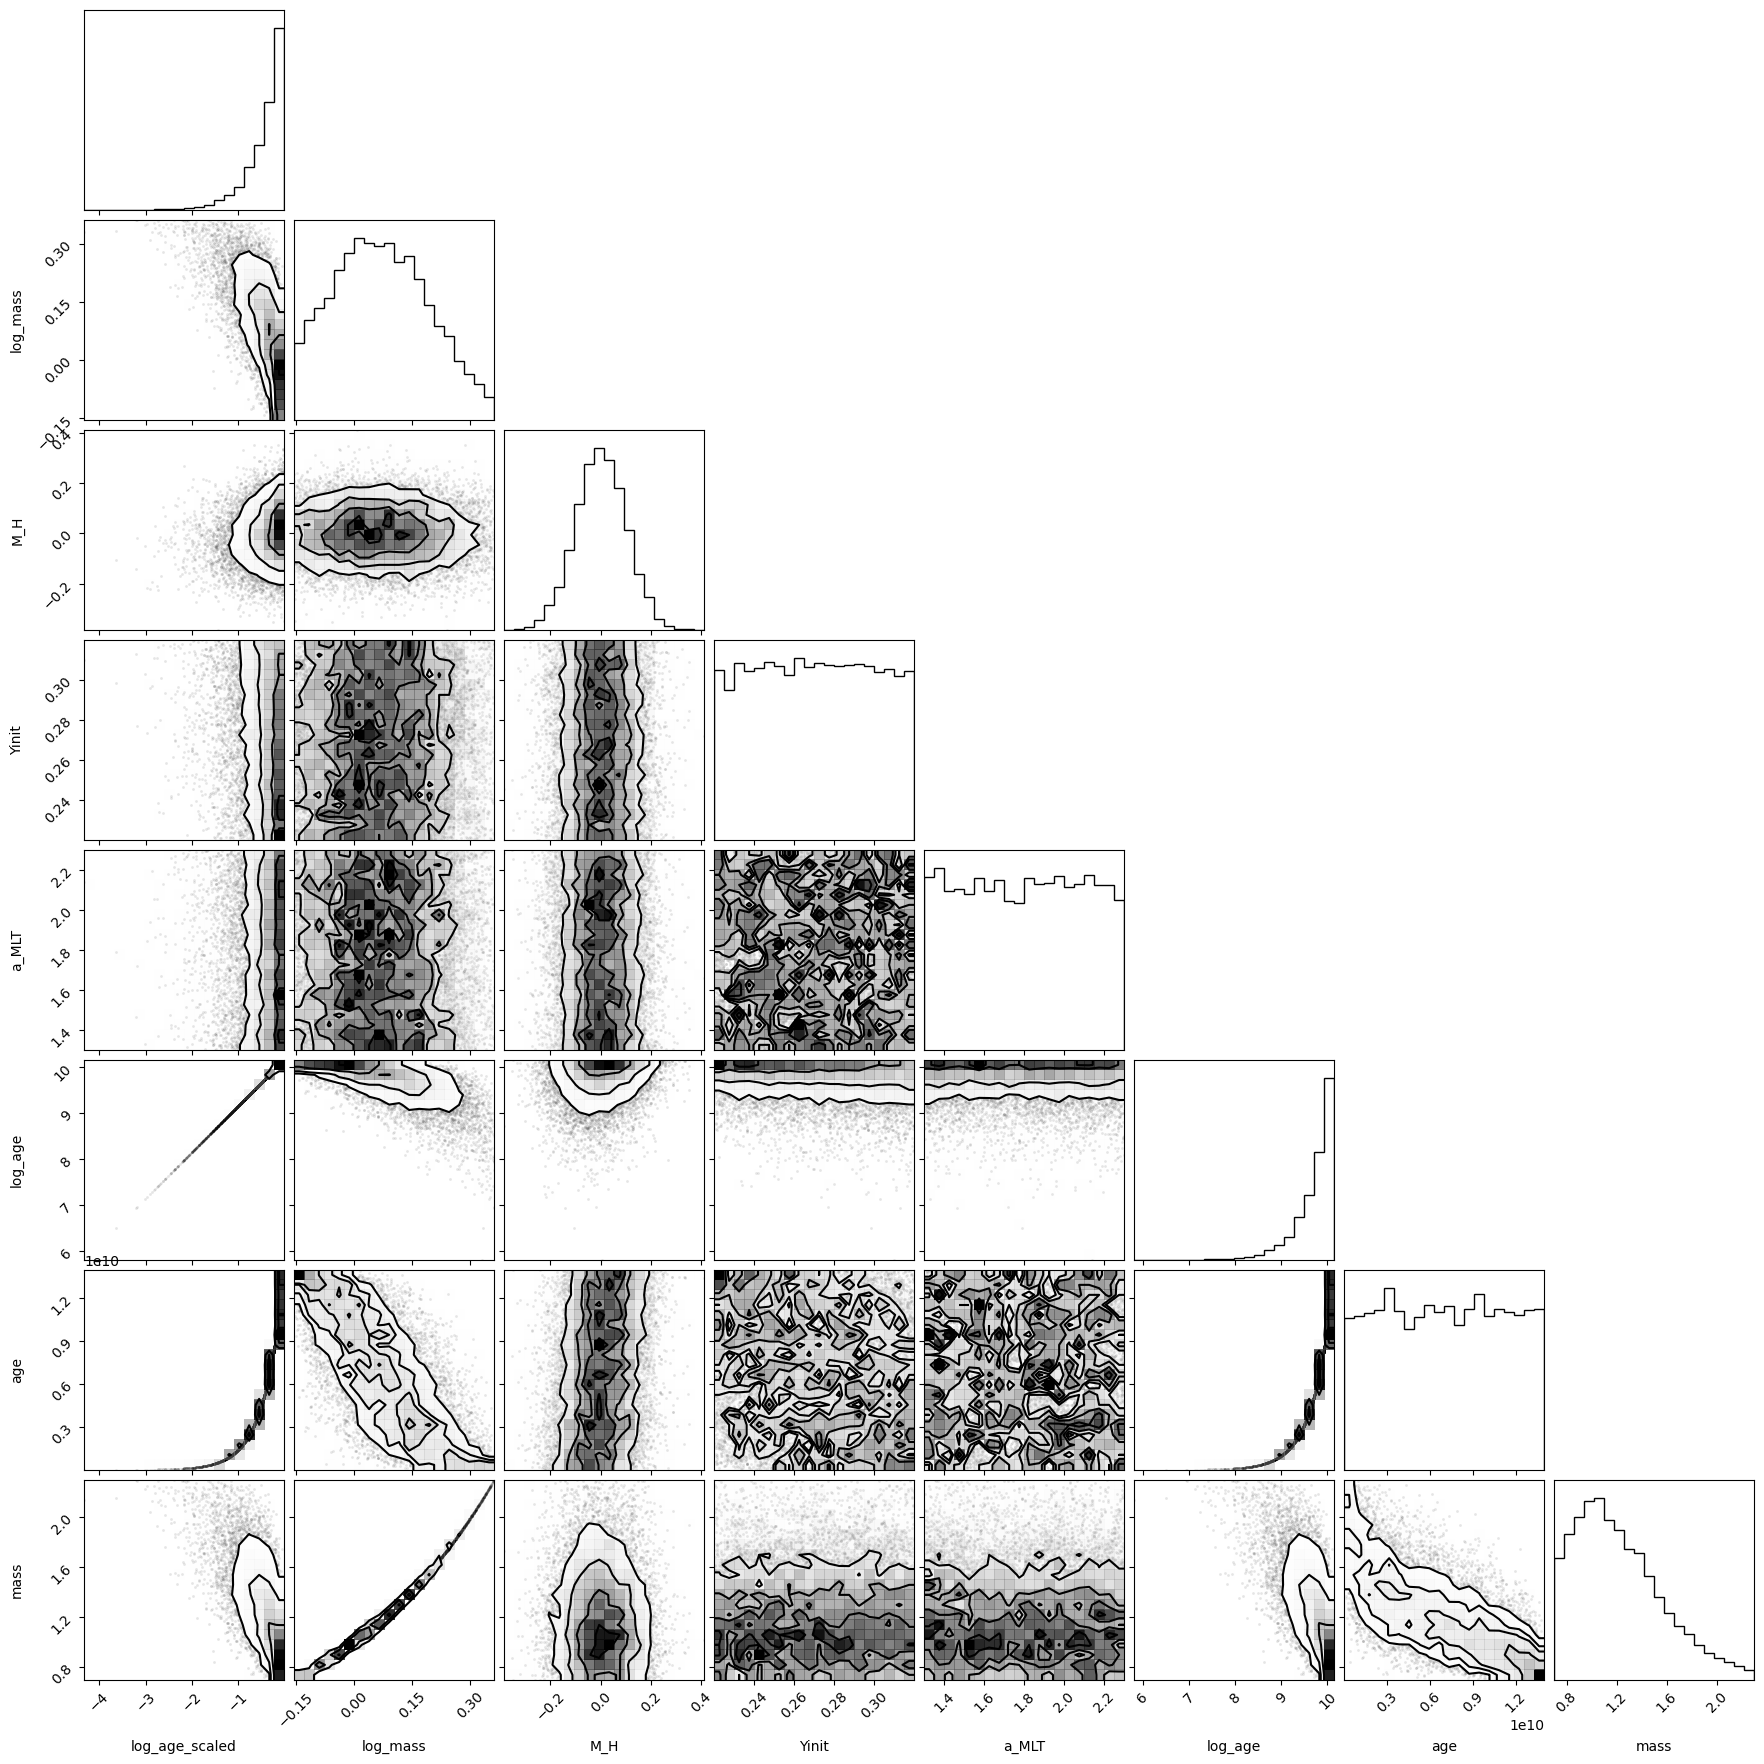

In [154]:
fig = corner(xs)

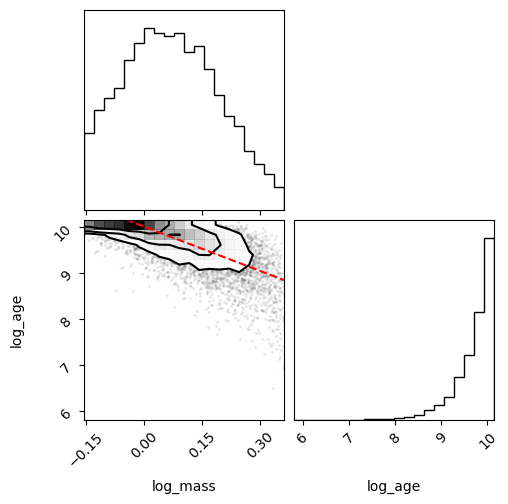

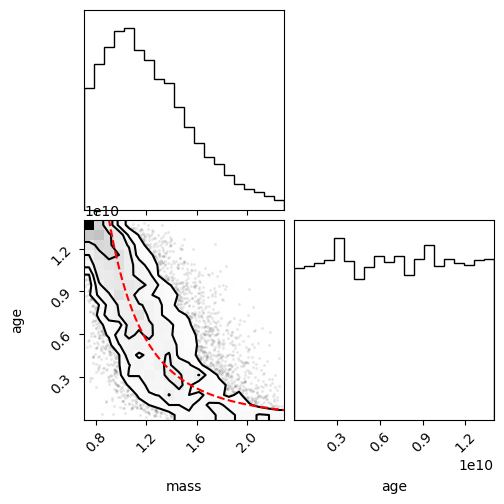

In [155]:
x = np.linspace(xs["log_mass"].min(), xs["log_mass"].max())
y = 10 - 3.2 * x

fig = corner(xs, var_names=["log_mass", "log_age"])
axes = fig.get_axes()
axes[2].plot(x, y, "r--")

fig = corner(xs, var_names=["mass", "age"])
axes = fig.get_axes()
axes[2].plot(10**x, 10**y, "r--")

In [ ]:
fig = corner(xs, var_names=["log_mass", "log_age"])
axes = fig.get_axes()
axes[2].plot(x, y, "r--")

fig = corner(xs, var_names=["mass", "age"])
axes = fig.get_axes()
axes[2].plot(10**x, 10**y, "r--")

In [150]:
keys = ["log_age", "log_Teff", "log_L"]
primary, secondary = calculate_eep(grid, keys)
grid["phase"] = primary
grid["EEP"] = secondary

In [151]:
grid = grid.drop(index=grid[grid.phase == -1].index).reset_index()
grid.head()

,level_0,index,track,star,star_mass,Yinit,Zinit,amlt,fov_core,fov_shell,...,delta_X,log_numax,numax,density,M_H,log_mass,log_kron,kron,phase,EEP
0,4,4,7000,5,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,...,0.001608,3.532013,3404.180139,1.289707,-0.852135,-0.034662,7.402258,2.524983e+07,0,0.000000
1,5,5,7000,6,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,...,0.001875,3.531227,3398.025495,1.286202,-0.852135,-0.034662,7.439066,2.748309e+07,0,0.017941
2,6,6,7000,7,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,...,0.002592,3.529737,3386.391401,1.279550,-0.852135,-0.034662,7.523472,3.337891e+07,0,0.042945
3,7,7,7000,8,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,...,0.003644,3.528241,3374.746064,1.272896,-0.852135,-0.034662,7.621891,4.186889e+07,0,0.069534
4,8,8,7000,9,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,...,0.005195,3.526692,3362.730099,1.266089,-0.852135,-0.034662,7.733153,5.409447e+07,0,0.097459


<Axes: ylabel='Frequency'>

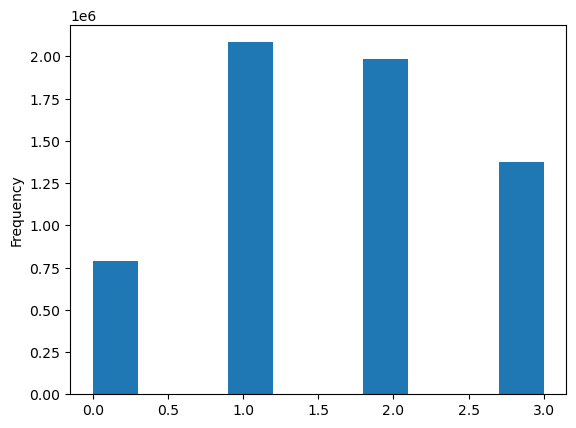

In [152]:
grid.phase.plot(kind="hist")

In [153]:
grid["star_age"]

0          3.259691e+07
1          3.548000e+07
2          4.309136e+07
3          5.405171e+07
4          6.983463e+07
               ...     
6228868    1.446116e+10
6228869    1.446395e+10
6228870    1.446496e+10
6228871    1.446593e+10
6228872    1.446687e+10
Name: star_age, Length: 6228873, dtype: float64

In [154]:
min_age = grid.groupby(["track", "phase"])["star_age"].min()
min_age

track  phase
0      0        6.751541e+07
       1        7.506258e+09
       2        1.567461e+10
       3        1.620770e+10
1      0        9.475297e+07
                    ...     
8190   3        1.616556e+09
8191   0        1.326268e+08
       1        1.590154e+10
       2        3.532054e+10
       3        3.625807e+10
Name: star_age, Length: 32232, dtype: float64

In [155]:
max_age = grid.groupby(["track", "phase"])["star_age"].max()
max_age

track  phase
0      0        7.406441e+09
       1        1.566237e+10
       2        1.620362e+10
       3        1.708846e+10
1      0        2.419738e+09
                    ...     
8190   3        1.812387e+09
8191   0        1.570190e+10
       1        3.528191e+10
       2        3.623977e+10
       3        3.798687e+10
Name: star_age, Length: 32232, dtype: float64

In [156]:
delta_age = (max_age - min_age) / max_age.groupby("track").max()
delta_age

track  phase
0      0        0.429467
       1        0.477288
       2        0.030957
       3        0.051541
1      0        0.558926
                  ...   
8190   3        0.108051
8191   0        0.409859
       1        0.510186
       2        0.024199
       3        0.045511
Name: star_age, Length: 32232, dtype: float64

In [159]:
cumulative_age = delta_age.groupby("track").cumsum()

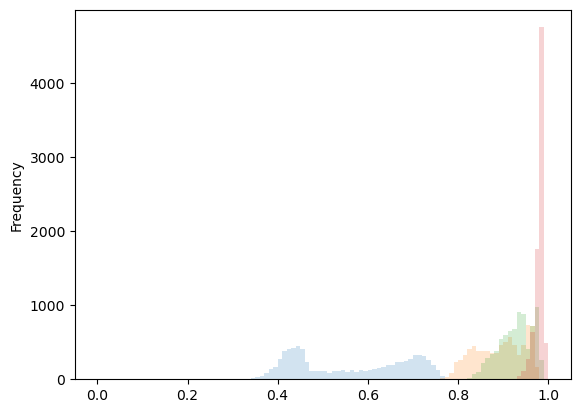

In [162]:
cumulative_age.groupby("phase").plot(kind="hist", range=(0, 1), bins=100, alpha=0.2);

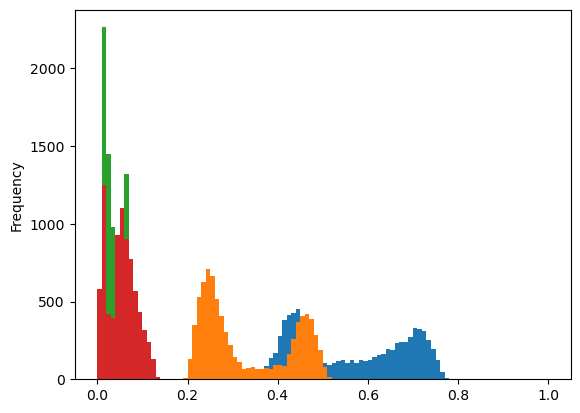

In [60]:
delta_age.groupby("phase").plot(kind="hist", range=(0, 1), bins=100);

In [64]:
delta_age.name = "delta_age"
delta_age

track  phase
0      0        0.429467
       1        0.477288
       2        0.030957
       3        0.051541
1      0        0.558926
                  ...   
8190   3        0.108051
8191   0        0.409859
       1        0.510186
       2        0.024199
       3        0.045511
Name: delta_age, Length: 32232, dtype: float64

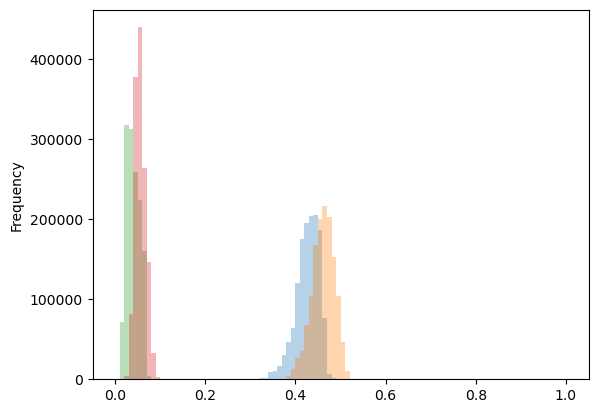

In [74]:
mask = grid.loc[grid.star_mass < 1.2, "track"]
delta_age.loc[mask].groupby("phase").plot(kind="hist", range=(0, 1), bins=100, alpha=0.33);

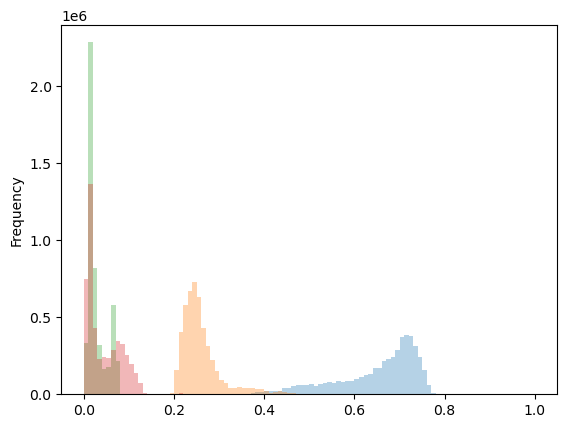

In [75]:
mask = grid.loc[grid.star_mass > 1.2, "track"]
delta_age.loc[mask].groupby("phase").plot(kind="hist", range=(0, 1), bins=100, alpha=0.33);

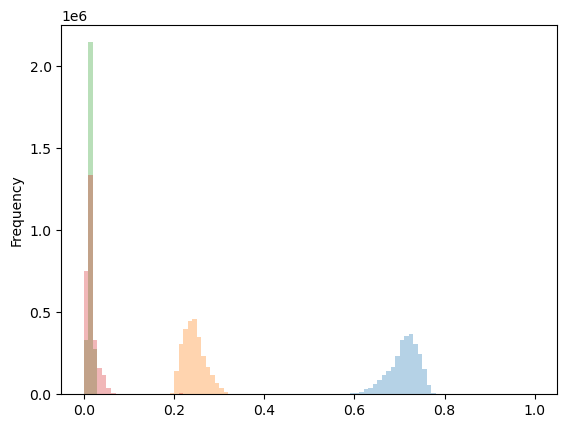

In [76]:
mask = grid.loc[grid.star_mass > 1.8, "track"]
delta_age.loc[mask].groupby("phase").plot(kind="hist", range=(0, 1), bins=100, alpha=0.33);

In [78]:
grid["log_mass"] = np.log10(grid.star_mass)

In [80]:
grid["log_Z"] = np.log10(grid.Zinit)